## Load modules and read in data

First, we will import all the modules needed for this analysis.

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
from glob import glob
import os
import random

# Set seed to 127
random.seed(127)

%load_ext rpy2.ipython

Since we're passing back and forth between R and python here, next we'll load the needed 

In [2]:
%%R 

suppressPackageStartupMessages({
    library(cowplot)
    library(ggseg)
    library(patchwork)
    library(tidyverse)
})

# Set cowplot theme
theme_set(theme_cowplot())

In [3]:
# Define data directory
infotheory_measure_dir = "infotheory_measures/"

# Load SPI groupings
infotheory_measure_info = pd.read_csv("data/infotheory_measure_info.csv")

# Load results for HCP participant 298051
subject_ID = "298051"
HCP_rsfMRI_info_theory_res = (pd.read_csv(f"data/HCP_{subject_ID}_rsfMRI_infotheory_measures.csv")
                              .merge(infotheory_measure_info, on="Measure", how='left')
                              [['Measure', 'Measure_name', 'Group', 'Group_number', 'region_from', 'region_to', 'value']])

Let's check out what the computed information-theoretic time-series measures look like:

In [4]:
HCP_rsfMRI_info_theory_res.head()

,Measure,Measure_name,Group,Group_number,region_from,region_to,value
0,entropy_kozachenko,Entropy,Single-process order-independent,1,lateraloccipital,lateraloccipital,1.398528
1,AIS_kraskov,Active information storage,Single-process order-dependent,4,lateraloccipital,lateraloccipital,0.578941
2,entropy_kozachenko,Entropy,Single-process order-independent,1,parstriangularis,parstriangularis,1.441374
3,AIS_kraskov,Active information storage,Single-process order-dependent,4,parstriangularis,parstriangularis,0.268617
4,je_kozachenko,Joint entropy,"Pairwise order-independent, undirected",2,lateraloccipital,parstriangularis,2.838691


There's several columns here to break down: 

* `Measure`: The name of the measure; specifically, for the example `entropy_kozachenko`, this refers to (single-process) Shannon entropy, computed using a Kozachenko--Leonenko density estimator in JIDT. 
* `Measure_Name`: A fully spelled-out version of the measure name.
* `Group`: Which of the six broad categories in which we classify this measure.
* `Group_number`: The number assigned to that group in our review, which is defined in order to ensure consistent color mapping.
* `region_from`: In the case of a pairwise measure, this is the 'source' region -- noting that the 'to' and 'from' distinction is only relevant for directed pairwise measures, such as transfer entropy. For a single-process measure, this simply refers to the brain area in which the measure was computed (and that region name will be duplicated in the `region_to` column).
* `region_to`: In the case of a pairwise measure, this is the 'target' region. 
* `value`: The value of the measure in the corresponding region (or region--region pair).

With that, let's plot one of our measures in the brain! We can use active information storage (AIS) as an example:

In [5]:
HCP_rsfMRI_info_theory_res.head()

,Measure,Measure_name,Group,Group_number,region_from,region_to,value
0,entropy_kozachenko,Entropy,Single-process order-independent,1,lateraloccipital,lateraloccipital,1.398528
1,AIS_kraskov,Active information storage,Single-process order-dependent,4,lateraloccipital,lateraloccipital,0.578941
2,entropy_kozachenko,Entropy,Single-process order-independent,1,parstriangularis,parstriangularis,1.441374
3,AIS_kraskov,Active information storage,Single-process order-dependent,4,parstriangularis,parstriangularis,0.268617
4,je_kozachenko,Joint entropy,"Pairwise order-independent, undirected",2,lateraloccipital,parstriangularis,2.838691


In [6]:
%%R -i HCP_rsfMRI_info_theory_res

AIS_data <- HCP_rsfMRI_info_theory_res %>%
    filter(Measure=='AIS_kraskov')

AIS_data %>% head()

       Measure               Measure_name                          Group
1  AIS_kraskov Active information storage Single-process order-dependent
3  AIS_kraskov Active information storage Single-process order-dependent
14 AIS_kraskov Active information storage Single-process order-dependent
25 AIS_kraskov Active information storage Single-process order-dependent
36 AIS_kraskov Active information storage Single-process order-dependent
47 AIS_kraskov Active information storage Single-process order-dependent
   Group_number              region_from                region_to      value
1             4         lateraloccipital         lateraloccipital 0.57894101
3             4         parstriangularis         parstriangularis 0.26861733
14            4         superiorparietal         superiorparietal 0.44474224
25            4       posteriorcingulate       posteriorcingulate 0.05387672
36            4     lateralorbitofrontal     lateralorbitofrontal 0.05644233
47            4 rostralante

merging atlas and data by 'label'


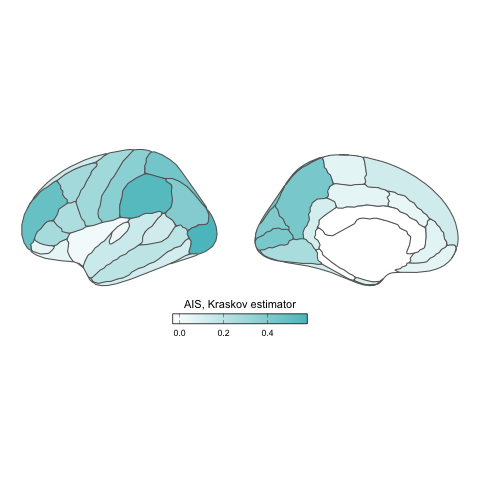

In [7]:
%%R -i HCP_rsfMRI_info_theory_res

# Filter all info theory measures to get the AIS measure
AIS_data <- HCP_rsfMRI_info_theory_res %>%
    filter(Measure=='AIS_kraskov')

# The color for AIS is #59C1C7 
AIS_color <- "#59C1C7"

# Pipe the AIS results to ggseg
AIS_data %>%
    # This step is to explicitly define a 'label' column needed to map to the 
    # dk (Desikan-Killiany) atlas in ggseg
    mutate(label = paste0("lh_", region_to)) %>%
    ggseg(atlas = dk, mapping=aes(fill=value),
          position = "stacked", colour = "gray40", hemisphere="left") +
    theme_void() +
    labs(fill = "AIS, Kraskov estimator") +
    theme(plot.title = element_blank(),
            legend.key.width = unit(0.95, "cm"),
            legend.key.height = unit(0.35, "cm"),
            legend.position = "bottom") +
    guides(fill = guide_colourbar(title.position="top", title.hjust = 0.5,
                                  frame.colour = "black", ticks.colour = "black")) +
    scale_fill_gradient(low="white", high=AIS_color, na.value="white")

You can reuse the above code block to generate a brain map for any specific measure of interest. 
To render all measures in one figure (with a lot of brains...that requires fussing about with in Inkscape after you save!), here's how you could do so:

`summarise()` has grouped output by 'region_to', 'Measure_name'. You can
override using the `.groups` argument.
Joining with `by = join_by(label)`


merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
merging atlas and data by 'label', 'atlas', 'type', 'hemi', 'side', 'region', 'roi'
In addition: Warning message:
In left_join(., as_tibble(dk)) :
  Detected an

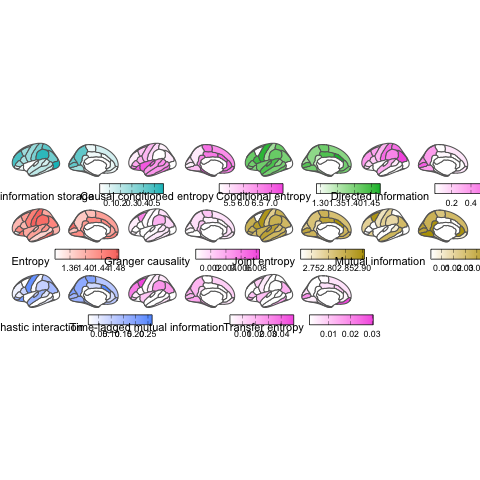

In [8]:
%%R -i HCP_rsfMRI_info_theory_res

# Generate default color palette
gg_color_hue <- function(n) {
      hues = seq(15, 375, length = n + 1)
      hcl(h = hues, l = 65, c = 100)[1:n]
      }
group_colors <- gg_color_hue(6)

# Let's plot this in the brain
mean_measure_value_by_region <- HCP_rsfMRI_info_theory_res %>%
  group_by(region_to, Measure_name, Group_number) %>%
  summarise(mean_value = mean(value, na.rm=T)) %>%
  ungroup() %>%
  mutate(label = paste0("lh_", region_to),
         mean_value = ifelse(mean_value<0, NA_real_, mean_value))
  
mean_measure_value_by_region_dk <- mean_measure_value_by_region %>%
  left_join(., as_tibble(dk))

plot_list <- list()
for (measure in unique(mean_measure_value_by_region_dk$Measure_name)) {
      this_measure_data <- subset(mean_measure_value_by_region_dk, Measure_name==measure)
      measure_group_color <- group_colors[this_measure_data$Group_number][1]
      p <- mean_measure_value_by_region_dk %>%
            filter(Measure_name==measure) %>%
            ggseg(atlas = dk, 
                  # mapping = aes(fill = mean_value_norm),
                  mapping=aes(fill=mean_value),
                  position = "stacked", colour = "gray40", hemisphere="left") +
            theme_void() +
            labs(fill = measure) +
            theme(plot.title = element_blank(),
                  legend.key.width = unit(0.45, "cm"),
                  legend.key.height = unit(0.35, "cm"),
                  legend.position = "bottom") +
            guides(fill = guide_colourbar(frame.colour = "black", ticks.colour = "black")) +
            scale_fill_gradient(low="white", high=measure_group_color, na.value="white")
      plot_list[[measure]] <- p
}

wrap_plots(plot_list)
# ggsave("figures/figure_drafting/HCP_rsfMRI_info_theory_measures_in_brain.svg", width=10, height=5, units="in", dpi=300)